In [101]:
import pandas as pd
from rich.jupyter import display
diabetes = pd.read_csv('data/diabetes.csv', sep=',')
train = pd.read_csv('data/train.csv', sep=',')
test = pd.read_csv('data/test.csv', sep=',')
dia_1 = pd.read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv', sep=',')
dia_2 = pd.read_csv('data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv', sep=',')
dia_3 = pd.read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv', sep=',')

__Что в diabetes?__

В таблице diabetes собраны данные о 768 женщинах индейского происхождения Пима в возрасте от 21 до 81 лет, у которых измеряли ИМТ, ДАД, толщину кожной складки трицепса, глюкозу через 2 часа в ПГТТ, инсулин; отразили наследственность по диабету и количество беременностей. 
Пропущенных значений, на первый взгляд, нет. Однако, при описании каждого из столбцов встречается 0 в min: уровень глюкозы, уровень ДАД, толщина кожной складки трицепса, инсулин, ИМТ. Такого в живом организме быть не может, а значение 0 может повлиять на общие выводы. Допускаем, что число беременностей может быть 0, поэтому это значение меня относительно устраивает.
Прежде чем анализировать факторы риска, которые способствуют развитию СД, я заменю 0 на None.

In [102]:
def change_0 (meaning):
    """Заменить 0 на None, остальные данные не трогать"""
    if meaning == 0:
        return None
    else:
        return meaning

In [103]:
diabetes['Glucose'] = diabetes['Glucose'].apply(change_0)
diabetes ['BloodPressure'] = diabetes['BloodPressure'].apply(change_0)
diabetes['SkinThickness'] = diabetes['SkinThickness'].apply(change_0)
diabetes['Insulin'] = diabetes['Insulin'].apply(change_0)
diabetes['BMI'] = diabetes['BMI'].apply(change_0)

Проверим какие факторы связаны с развитием диабета. Предположим, что развитию диабета может способствовать: высокий паритет, высокое ДАД, высокий ИМТ, возраст, толщина складки, отягощенная наследственность.

In [104]:
diabetes.pivot_table(
    values=['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age', 'DiabetesPedigreeFunction'],
    aggfunc=['mean', 'median', 'min', 'max'],
    columns='Outcome'
)

mean               median              min  \
Outcome                            0           1        0        1       0   
Age                        31.190000   37.067164   27.000   36.000  21.000   
BMI                        30.859674   35.406767   30.100   34.300  18.200   
BloodPressure              70.877339   75.321429   70.000   74.500  24.000   
DiabetesPedigreeFunction    0.429734    0.550500    0.336    0.449   0.078   
Insulin                   130.287879  206.846154  102.500  169.500  15.000   
Pregnancies                 3.298000    4.865672    2.000    4.000   0.000   
SkinThickness              27.235457   33.000000   27.000   32.000   7.000   

                                      max          
Outcome                        1        0       1  
Age                       21.000   81.000   70.00  
BMI                       22.900   57.300   67.10  
BloodPressure             30.000  122.000  114.00  
DiabetesPedigreeFunction   0.088    2.329    2.42  
Insulin                   14.000  744.000  846.00  
Pregnancies                0.000   13.000   17.00  
SkinThickness              7.000   60.000   99.00

Делаю вывод, что факторы, связанные с развитием диабета это: 4 и более беременности; возраст 36 лет и старше; ИМТ 35 и более (Ожирение 2 степени); DPF 0.5 и выше; толщина подкожной складки 33 и более; уровень инсулина.

Уровень ДАД не является фактором риска, т.к. среднее АД не отличалось в группах с СД и без него, при этом максимальное значение ДАД в группе у пациенток без СД. Возможно, мы бы увидели другие результаты, если бы это было САД.


__Объединение train и test__ 

В test 16 колонок, 848 строк. В train 17 колонок, 3390 строк. В датасетах test и train одним и тем же параметрам соответствуют колонки: все, кроме TenYearCHD. Их можно объединить горизонтально, по строкам. Общее количество строк должно быть 4238.


In [105]:
train_test = pd.concat([train, test], axis=0)
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4238 entries, 0 to 847
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   sex              4238 non-null   object 
 4   is_smoking       4238 non-null   object 
 5   cigsPerDay       4209 non-null   float64
 6   BPMeds           4185 non-null   float64
 7   prevalentStroke  4238 non-null   int64  
 8   prevalentHyp     4238 non-null   int64  
 9   diabetes         4238 non-null   int64  
 10  totChol          4188 non-null   float64
 11  sysBP            4238 non-null   float64
 12  diaBP            4238 non-null   float64
 13  BMI              4219 non-null   float64
 14  heartRate        4237 non-null   float64
 15  glucose          3850 non-null   float64
 16  TenYearCHD       3390 non-null   float64
dtypes: float64(10), int6

In [106]:
train_test = train_test.drop('TenYearCHD', axis=1)

__Что в train_test?__

Это исследование жителей города Фрамингем, штат Массачусетс. В объединенном датасете у нас есть такие данные: id, возраст, уровень образования, пол, факт курения, количество выкуриваемых сигарет в день, колонка BPMeds (медицинские данные, возможно удалю ее, не понимаю, какую информацию она нет), факт инсульта, факт АГ, факт СД, уровень холестерина, САД, ДАД, ИМТ, ЧСС, уровень глюкозы. Столбец риска развития ИБС есть только в датасете train, это расчетный показатель и при объединении 848 id будут без этого значения. Я удалю этот столбец, принимая во внимание то, что нас интересует СД, а сердечно-сосудистый риск.
Проанализируем данные на предмет пропущенных значений, для этого посмотрим на min и соотнесем с реальностью. Итого min == 0 у приемлемых показателей. Появились новые факты, которые можно отнести к факторам риска диабета: уровень образования, пол, факт курения, факт инсульта, уровень холестерина, САД, ЧСС. Проверим одинаковы ли выводы с предыдущим датасетом по данным: возраст, уровень ДАД, ИМТ.


In [107]:
train_test.pivot_table(
    values=['age', 'education', 'prevalentStroke', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate'],
    aggfunc=['mean', 'median', 'min', 'max'],
    columns='diabetes'
)

mean               median             min          \
diabetes                  0           1        0       1       0       1   
BMI               25.744730   28.003178   25.355   27.78   15.54   17.17   
age               49.443933   54.926606   49.000   55.00   32.00   36.00   
diaBP             82.796077   86.582569   82.000   85.00   48.00   51.00   
education          1.985349    1.735849    2.000    1.00    1.00    1.00   
heartRate         75.783188   79.504587   75.000   78.00   44.00   52.00   
prevalentHyp       0.304674    0.532110    0.000    1.00    0.00    0.00   
prevalentStroke    0.005813    0.009174    0.000    0.00    0.00    0.00   
sysBP            131.953984  147.444954  128.000  143.50   83.50   85.50   
totChol          236.429412  247.759259  234.000  240.00  107.00  150.00   

                   max          
diabetes             0       1  
BMI               56.8   44.27  
age               70.0   68.00  
diaBP            142.5  140.00  
education          4.0    4.00  
heartRate        143.0  115.00  
prevalentHyp       1.0    1.00  
prevalentStroke    1.0    1.00  
sysBP            295.0  235.00  
totChol          696.0  600.00

Делаю вывод, что фактором риска развития СД является:

ИМТ 28 и более (против 35 в датасете diabetes);

Возраст 54 и старше (против 36 лет в датасете diabetes);

На большой выборке вижу увеличение значения таких факторов риска, как: ДАД, САД, уровень холестерина.

Не является: уровень ЧСС.


__Объединение третьего датасета__

Я не смогла воспользоваться методом merge, чтобы таблицы объединились по diabetes_binary как diabetes_012, возникла memoryError: Unable to allocate 57.5 GiB for an array with shape (7717233564,) and data type int64. Я не смогла с ней справиться, поэтому везде использую concat и посимвольно изменяю имя столбца для беспроблемного конкатенирования.

In [108]:
dia_2 = dia_2.rename(columns={'Diabetes_binary' : 'Diabetes_012'})

"""Эти таблицы содержат 0/1/2 в столбце диабет, а в таблице dia_2 этот показатель бинарный и преддиабет это 1. Заменю 2 на 1."""

dia_1['Diabetes_012'] = dia_1['Diabetes_012'].apply(lambda x: 1 if x == 2 else x)
dia_3['Diabetes_012'] = dia_3['Diabetes_012'].apply(lambda x: 1 if x == 2 else x)

In [109]:
dia_all = pd.concat(
    [dia_1, dia_2, dia_3],
    ignore_index=True
)

In [110]:
"""Диагноз АГ буду ставить по ДАД, т.к. в первой таблиц есть только ДАД, во второй и ДАД и САД, а в третьей только наличие/отсуствие АГ"""

def get_bp(bp):
    """1 - наличие АГ, 0 - отсутствие АГ"""
    if bp >= 90:
        return 1
    else:
        return 0

In [111]:
""" Для таблицы diabetes создам столбец HighBP"""

diabetes['HighBP'] = diabetes['BloodPressure'].apply(get_bp)
train_test['HighBP'] = train_test['diaBP'].apply(get_bp)

In [112]:
"""Сделаю одинаковые столбцы в трех таблицах"""

diabetes = diabetes.rename(columns={'Outcome' : 'Diabetes'})
dia_all = dia_all.rename(columns={'Diabetes_012': 'Diabetes'})
train_test = train_test.rename(columns={'sex' : 'Sex', 'age' : 'Age', 'diabetes' : 'Diabetes'})

In [113]:
"""в третьей таблице male это 1, а female 0 (https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook/notebook), поэтому во второй таблице будет также"""

train_test['Sex'] = train_test['Sex'].apply(lambda x: 0 if x == 'F' else 1)

In [114]:
"""В первой таблице только женщины, создам столбец Sex"""

diabetes['Sex'] = [0] * 768

In [115]:
"""Создам маски таблиц с общими столбцами для всех трех таблиц"""

mask_1 = diabetes.loc[:, ['Age', 'Sex', 'HighBP', 'Diabetes', 'BMI']]
mask_2 = dia_all.loc[:, ['Age', 'Sex', 'HighBP', 'Diabetes', 'BMI']]
mask_3 = train_test.loc[:, ['Age', 'Sex', 'HighBP', 'Diabetes', 'BMI']]

In [116]:
general_dataset = pd.concat(
    [mask_1, mask_2, mask_3],
    ignore_index=True
)
print(general_dataset)

         Age  Sex  HighBP  Diabetes    BMI
0       50.0  0.0     0.0       1.0  33.60
1       31.0  0.0     0.0       0.0  26.60
2       32.0  0.0     0.0       1.0  23.30
3       21.0  0.0     0.0       0.0  28.10
4       33.0  0.0     0.0       1.0  43.10
...      ...  ...     ...       ...    ...
583053  46.0  0.0     0.0       0.0  27.42
583054  58.0  0.0     0.0       0.0  23.08
583055  55.0  1.0     0.0       0.0  26.41
583056  45.0  0.0     1.0       0.0  22.86
583057  56.0  1.0     0.0       0.0  23.44

[583058 rows x 5 columns]


In [117]:
general_dataset.pivot_table(
    values=['Age', 'Sex', 'HighBP', 'Diabetes', 'BMI'],
    aggfunc=['mean', 'median', 'min', 'max', 'count'],
    columns='Diabetes'
)

mean            median         min         max         count  \
Diabetes        0.0        1.0    0.0   1.0   0.0   1.0   0.0   1.0     0.0   
Age        8.179800   9.462443    8.0  10.0   1.0   1.0  81.0  70.0  467381   
BMI       27.730294  31.850679   27.0  31.0  12.0  13.0  98.0  98.0  467355   
HighBP     0.369938   0.740925    0.0   1.0   0.0   0.0   1.0   1.0  467381   
Sex        0.433535   0.474692    0.0   0.0   0.0   0.0   1.0   1.0  467381   

                  
Diabetes     1.0  
Age       115677  
BMI       115673  
HighBP    115677  
Sex       115677

Нужно выяснить у кого в популяции чаще встречается сахарный диабет, зависимость наличия диабета от возраста, ИМТ, пола и наличия АГ.

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

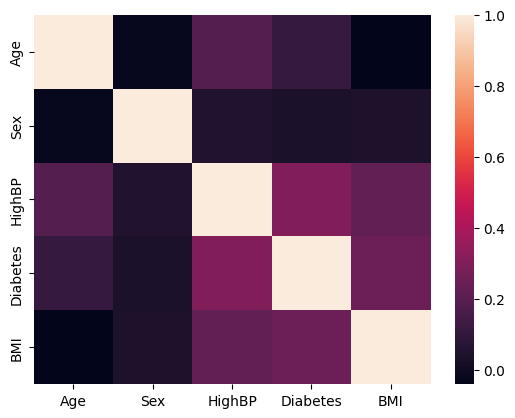

In [119]:
sns.heatmap(general_dataset.corr());

In [120]:
age = general_dataset['Age']
BMI = general_dataset['BMI']

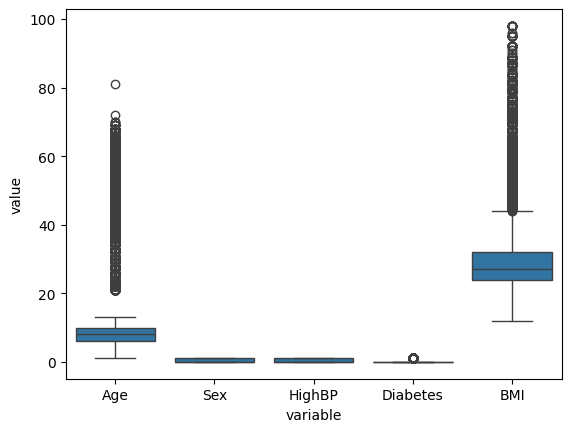

In [121]:
pd.DataFrame(data=general_dataset, columns=['Age', 'BMI'])
sns.boxplot(x='variable', y='value', data=pd.melt(general_dataset));

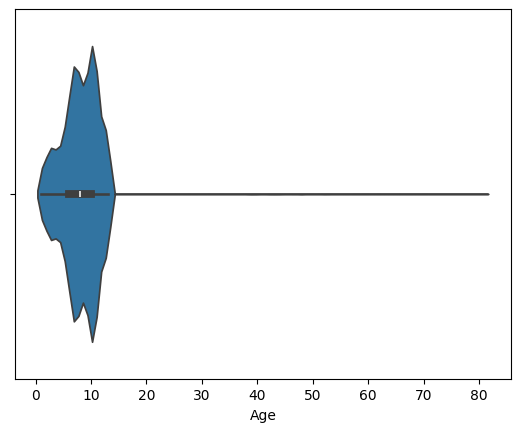

In [122]:
sns.violinplot(x='Age', data=general_dataset);

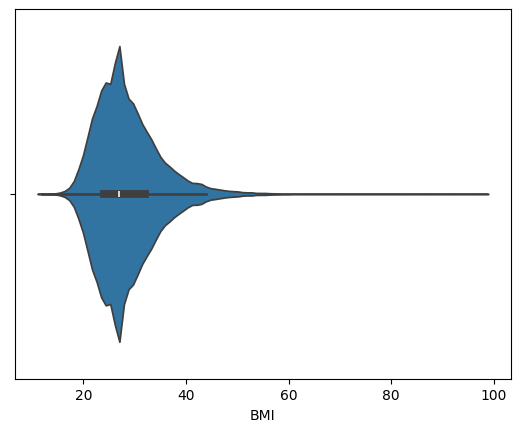

In [123]:
sns.violinplot(x='BMI', data=general_dataset);

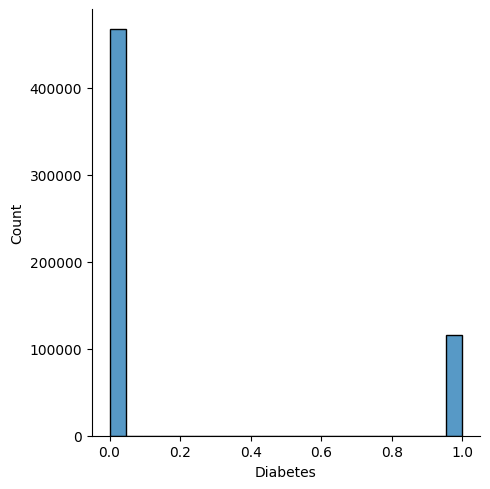

In [124]:
sns.displot(data=general_dataset, x='Diabetes')